# Подключение к хранилищу

In [1]:
import pyspark
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import numpy as np
import collections
import scipy
import scipy.stats

In [2]:

spark = pyspark.sql.SparkSession.builder.appName("startup_app") \
    .config("spark.mongodb.input.uri", "mongodb://mongo/startup_db.startups_coll") \
    .config('spark.jars', 'jars/mongo-spark-connector_2.11-2.4.2-assembly.jar') \
    .config('spark.jars.packages', 'org.mongodb.spark:mongo-spark-connector_2.11:2.4.2') \
    .getOrCreate()


In [6]:
df = spark.read.format('mongo').load()

In [7]:
df.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- angel_id: integer (nullable = true)
 |-- angel_url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- employees: string (nullable = true)
 |-- founders: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- link: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- bio: string (nullable = true)
 |-- location: string (nullable = true)
 |-- name: string (nullable = true)
 |-- raised: integer (nullable = true)
 |-- website: string (nullable = true)



# Построение запросов

### Распределение полученных инвестиций

In [8]:
raised = df.select('raised').toPandas()
raised['raised'] = raised['raised'][raised['raised'] > 0]
raised = raised.dropna().to_numpy()

(array([7.349e+03, 3.340e+02, 1.570e+02, 9.600e+01, 5.300e+01, 3.300e+01,
        2.500e+01, 1.900e+01, 1.300e+01, 1.300e+01, 8.000e+00, 7.000e+00,
        6.000e+00, 8.000e+00, 2.000e+00, 4.000e+00, 6.000e+00, 1.000e+00,
        3.000e+00, 2.000e+00, 2.000e+00, 2.000e+00, 3.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00]),
 array([1.00000000e+00, 1.82400010e+07, 3.64800010e+07, 5.47200009e+07,
        7.29600009e+07, 9.12000009e+07, 1.09440001e+08, 1.27680001e+08,
        1.45920001e+08, 1.64160001e+08, 1.82400001e+08, 2.00640001e+08,
        2.18880001e+08, 2.37120001e+08, 2.55360001e+08, 2.73600001e+08,
        2.91840001e+08, 3.10080001e+08, 3.28320001e+08, 3.46560001e+08,
        3.648000

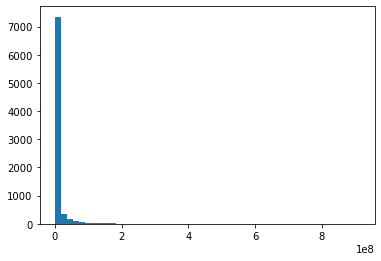

In [9]:
clean_raised = [c[0] for c in raised if c[0] < 100_000_0000] # remove outliers
plt.hist(clean_raised, bins=50)

## Диаграмма количества основателей

In [10]:
founders_counts = df.select(F.size('founders').alias('founders_count')).where(F.col('founders_count') > 0).toPandas()
founders_counts = founders_counts.to_numpy()[:, 0]

founders_counter = collections.Counter(founders_counts)

([<matplotlib.patches.Wedge at 0x7fdbe4264f50>,
 [Text(0.3637501432409184, 1.0381164834893102, '1'),
  Text(-0.9243869287597677, -0.5962455919653281, '2'),
  Text(0.7379737264872573, -0.8157173401457829, '3'),
  Text(1.0437807824716718, -0.3471623224700871, '5'),
  Text(1.086614366379332, -0.17108249114986349, '4'),
  Text(1.0999363669991413, -0.011831675820889375, '6'),
  Text(1.0999986031893518, -0.0017529921491908208, '7'),
  Text(1.09999991265787, -0.0004383522315291321, '8')],
 [Text(0.19840916904050096, 0.5662453546305328, '39.3%'),
  Text(-0.5042110520507823, -0.32522486834472436, '39.7%'),
  Text(0.402531123538504, -0.4449367309886088, '15.5%'),
  Text(0.5693349722572755, -0.18936126680186566, '0.9%'),
  Text(0.5926987452978174, -0.09331772244538007, '4.4%'),
  Text(0.5999652910904406, -0.00645364135684875, '0.3%'),
  Text(0.5999992381032827, -0.0009561775359222658, '0.0%'),
  Text(0.5999999523588381, -0.00023910121719770839, '0.0%')])

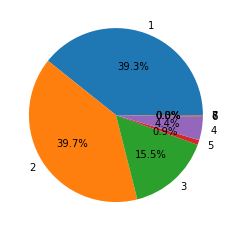

In [11]:

plt.pie([v for k,v in founders_counter.items()], autopct='%1.1f%%', labels=[k for k,v in founders_counter.items()])

### Корреляция количества инвестиций с количеством основателей

In [12]:
corr_df = df.select('raised', F.size('founders').alias('founders_count')).where(F.col('raised') < 100_000_000).toPandas()

In [13]:
corr_df

,raised,founders_count
0,5000,1
1,2500,0
2,10000,1
3,5000,1
4,4000,1
...,...,...
7999,75228850,2
8000,84000000,3
8001,59750000,1
8002,59500000,2


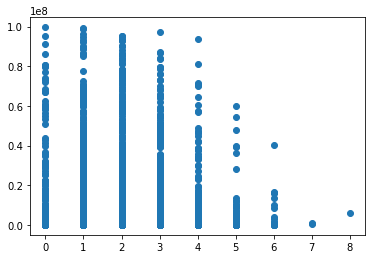

In [14]:
plt.scatter(corr_df['founders_count'], corr_df['raised'])

In [17]:

scipy.stats.mstats.pearsonr(corr_df['founders_count'], corr_df['raised']) 
# those variables are independent

(0.024711124374495647,
 masked_array(data=0.02705143,
              mask=False,
        fill_value=1e+20))

# Выводы

Пример показывает, что представленная система позволяет усваивать, хранить и анализировать потенциально большие объемы данных.  
Данная система легко разворачивается, может горизонтально масштабироваться и представляет гибкие инструменты для аналитика данных.  
Информация, полученная на основе примененной аналитики, была использована в исследовательской работе по курсу многомерного анализа данных, что показывает практическую полезность проекта.  

